# IMPORT LIBRARIES

In [ ]:
#Import libraries useful for the analysis

!pip install pydub
from google.colab import drive
import os
import shutil
import urllib
import zipfile
import glob
import sklearn
import numpy as np
import pydub
import librosa
import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="white", palette="muted")
import pandas as pd
import librosa.display
import random
from random import sample
from matplotlib.pyplot import figure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import statistics
from scipy.signal import savgol_filter
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import pickle
from sklearn import metrics
import timeit

np.random.seed(42)


#connect to drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


# LOAD DATA

## DEFINE NAME OF CLASSES

In [ ]:
#Names of the 50 different classes

classes_names = ["Dog", "Rooster", "Pig", "Cow", "Frog", "Cat", "Hen", "Insects",
                 "Sheep", "Crow", "Rain", "Sea Waves", "Crackling Fire", "Crickets",
                 "Chirping Birds", "Water Drops", "Wind", "Pouring Water", "Toilet Flush",
                 "Thunderstorm","Crying Baby","Sneezing","Clapping", "Breathing",
                 "Coughing", "Footsteps", "Laughing", "Brushing Teeth", "Snoring",
                 "Drinking", "Door Knock", "Mouse Click", "Keyboard Typing", "Door",
                 "Can Opening", "Washing Machine", "Vacuum Cleaner", "Clock Alarm",
                 "Clock Tick", "Glass Breaking", "Helicopter", "Chainsaw", "Siren",
                "Car Horn", "Engine", "Train", "Church Bells", "Airplane", "Fireworks",
                 "Hand Saw"] 

## DEFINE CLASS

In [ ]:
#Define a class containing all the useful information from each clip sampled
#Filename -> the name of the file
#Path -> path to file
#Direcorty -> directory that contains the file
#Category -> the class the clip belongs to in integer
#Audio -> audio file
#Fold -> cross validation fold the clip belongs to

#We also define some methods
#Raw -> gives the raw version of the data
#Mfcc -> computes Mel-frequency cepstral coefficients
#Logamplitude -> computes Mel spectrum
#Zcr -> computes zero crossing rate of each clip

class Clip:
    
    RATE = 44100   #All recordings in ESC are 44.1 kHz
    FRAME = 512    #Frame size in samples
    
    class Audio:
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            #Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            self.data = pydub.AudioSegment.silent(duration=5000)
            self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
            self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5) 
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = classes_names[abs(int(self.filename[-6:-4]))]
        self.audio = Clip.Audio(self.path)
        self.fold = int(self.filename[0])
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)
            self.raw = audio.raw
            
    def _compute_mfcc(self, audio):
        #MFCC computation with default settings
        self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.power_to_db(self.melspectrogram)
        #Get only the first 13 bands
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()
            
    def _compute_zcr(self, audio):
        #Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.FRAME))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}>'.format(self.filename)

## TESTING

In [ ]:
cd /content/drive/MyDrive/master/audio

/content/drive/MyDrive/master/audio


In [ ]:
#Load one random clip
clip = Clip("1-32318-A-0.wav")

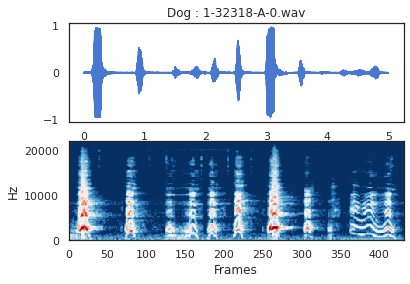

In [ ]:
#Plot Mel spectogram and raw data
plt.subplot(2, 1, 1)
plt.title('{0} : {1}'.format(clip.category, clip.filename))
plt.plot(np.arange(0, len(clip.raw)) / 44100.0, clip.raw)
   
plt.subplot(2, 1, 2)
librosa.display.specshow(clip.logamplitude, sr=44100, x_axis='frames', y_axis='linear', cmap='RdBu_r')
    
IPython.display.Audio(filename=clip.path, rate=Clip.RATE)

## LOAD ALL CLIPS

In [ ]:
#Load all clips and the relative classes
clips = []
classes = []
for filename in os.listdir():
  clips.append(Clip(filename))
  classes.append(abs(int(filename[-6:-4])))

# EXPLORATORY DATA ANALYSIS

## COMPARE CLIPS FROM THE SAME CLASS


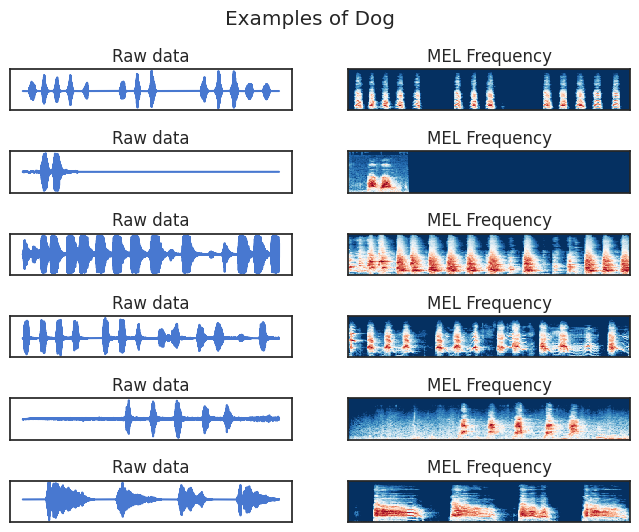

In [ ]:
#Here we compare clips coming from the same class, in this case we picked Dog bark

n=6
choice = 0
indices  = sample([index for (index, item) in enumerate(classes) if item == choice],n)
c=0

figure(figsize=(8, 6), dpi=100)
plt.suptitle("Examples of {0}".format(classes_names[choice]))


for i in range(0,n):
  c+=1
  plt.subplot(n, 2, c)
  plt.subplots_adjust(hspace=1)
  plt.title("Raw data")
  plt.plot(np.arange(0, len(clips[indices[i]].raw)) / 44100.0, clips[indices[i]].raw)
  plt.xticks([])
  plt.yticks([])

  c+=1
  plt.subplot(n, 2, c)
  plt.title("MEL Frequency")
  librosa.display.specshow(clips[indices[i]].logamplitude, sr=44100, cmap='RdBu_r')

## COMPARE CLIPS FROM DIFFERENT CLASSES

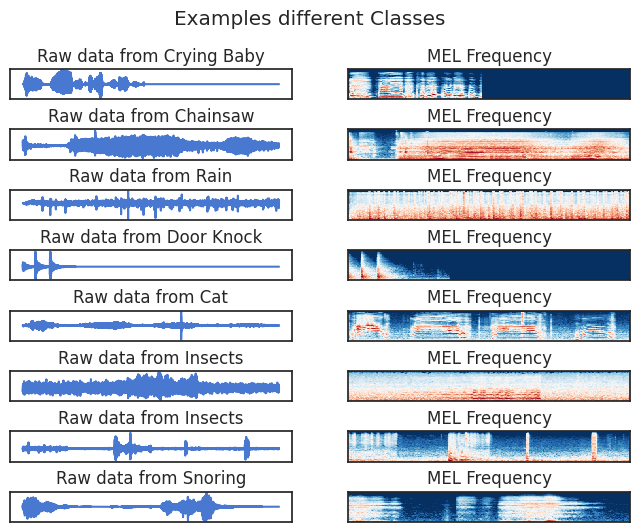

In [ ]:
#Here we show the difference between clips of different classes

n = 8

indices  = sample(range(0,2000), n)

figure(figsize=(8, 6), dpi=100)
plt.suptitle("Examples different Classes")

c=0
for i in range(0,n):
  c+=1
  plt.subplot(n, 2, c)
  plt.subplots_adjust(hspace=1)
  plt.title("Raw data from {0}".format(classes_names[classes[indices[i]]]))
  plt.plot(np.arange(0, len(clips[indices[i]].raw)) / 44100.0, clips[indices[i]].raw)
  plt.xticks([])
  plt.yticks([])

  c+=1
  plt.subplot(n, 2, c)
  plt.title("MEL Frequency")
  librosa.display.specshow(clips[indices[i]].logamplitude, sr=44100, cmap='RdBu_r')

In [ ]:
#Create dataframe containing the mean of the first two MFCC features and the standard deviation
#Same thing for zero crossing rate
#We want to see if these features can help us to classify the audio clips

df = pd.DataFrame(columns=['MFCC1_mean', 'MFCC2_mean', 'ZCR_mean', 'classes'])
chosen_classes = ['Dog', 'Rain', 'Sea Waves', 'Crying Baby', 
                  'Clock Tick', 'Sneezing', 'Helicopter', 'Chainsaw', 
                  'Rooster', 'Crackling Fire']
for i, clip in enumerate(clips):
  if clip.category in chosen_classes:
    mfcc1, mfcc2 = np.mean(clip.mfcc, axis = 0)[1:3]
    zcr = np.mean(clip.zcr)
    df.loc[i, ] = [mfcc1, mfcc2, zcr, clip.category]
  


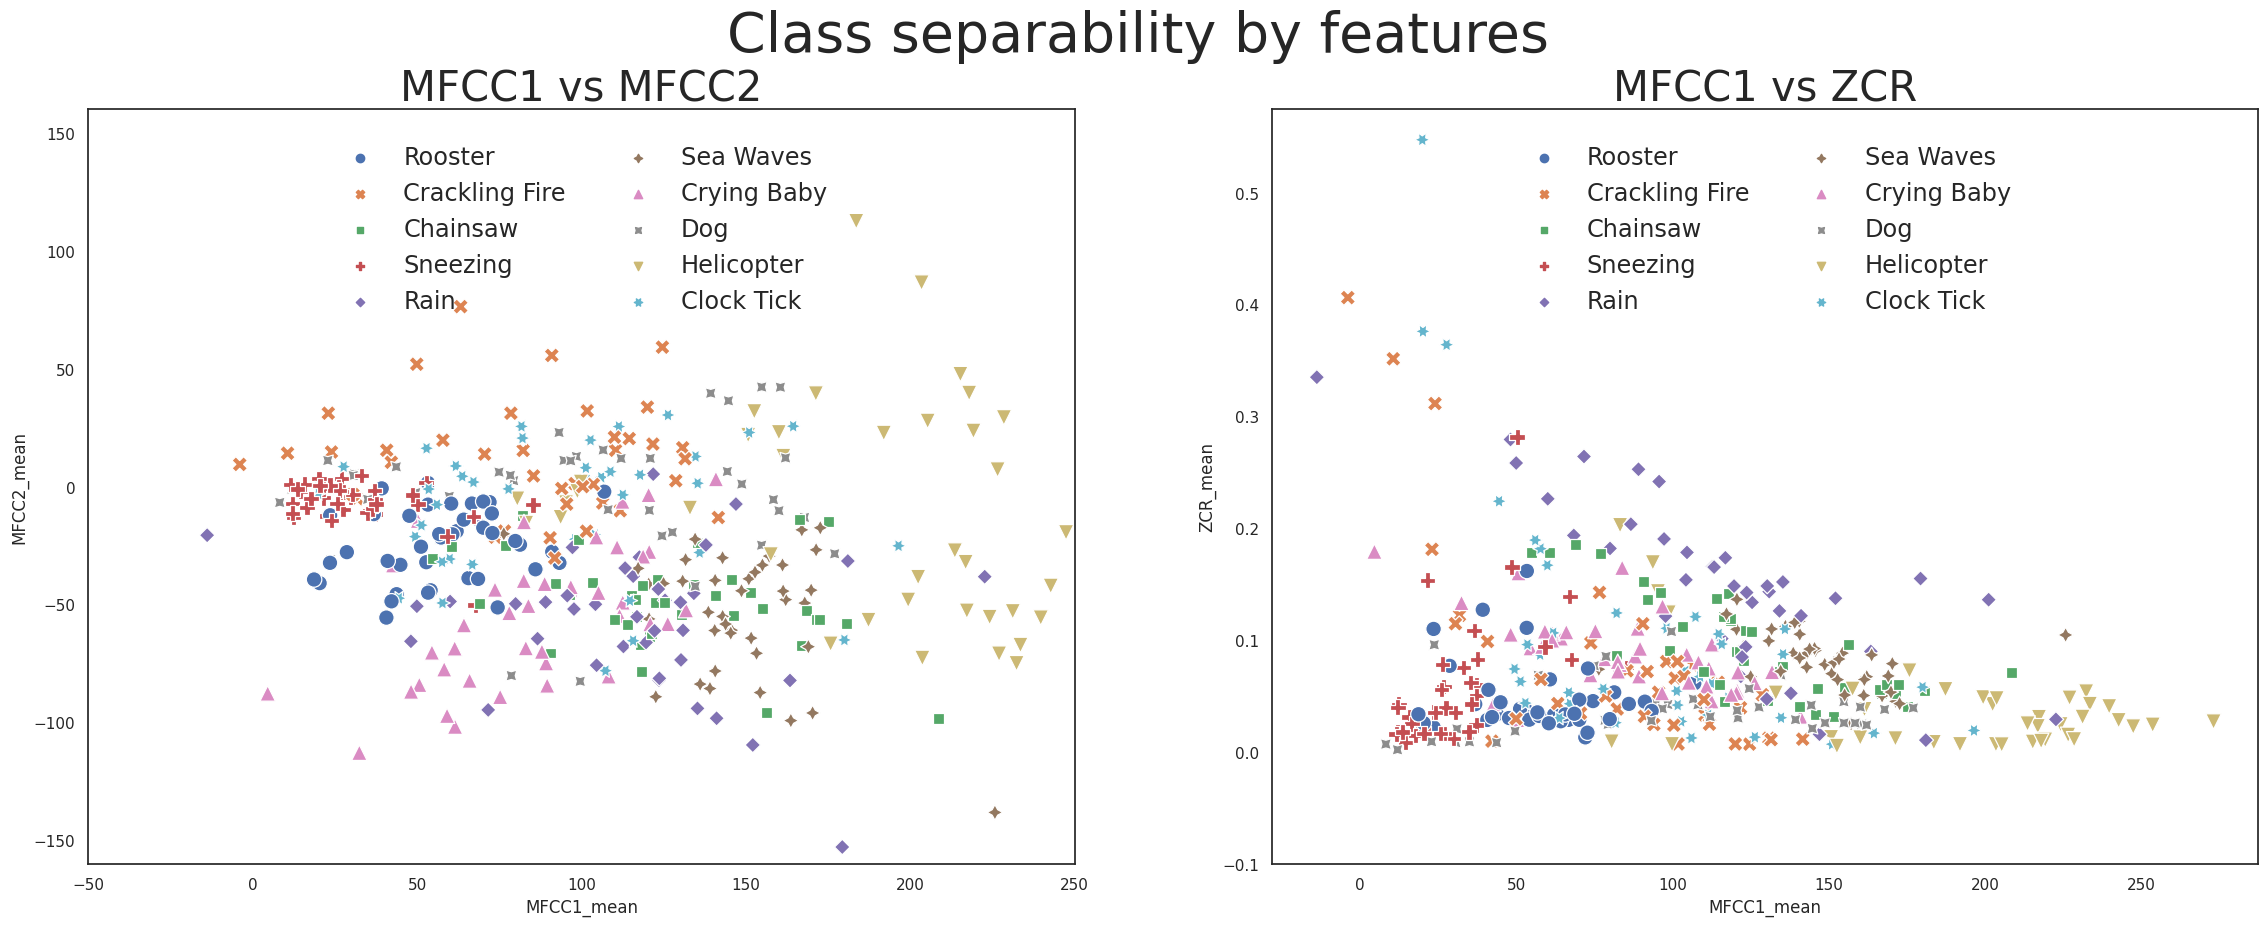

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatterplot with points colored by class and shaped by another class
figure(figsize=(28, 10), dpi=100)
plt.suptitle("Class separability by features", fontsize = 40)
plt.subplot(1, 2, 1)
sns.scatterplot(x="MFCC1_mean", y="MFCC2_mean", hue="classes", style = 'classes',
                data=df, 
                palette = 'deep',
                s = 125)
plt.ylim(-160, 160)
plt.xlim(-50, 250)
plt.legend(loc = 'upper center', ncol = 2, frameon=False, fancybox=False, borderpad=1.0, fontsize = 'x-large')
plt.title('MFCC1 vs MFCC2', fontsize = 30)

plt.subplot(1, 2, 2)
sns.scatterplot(x="MFCC1_mean", y="ZCR_mean", hue="classes", style = 'classes',
                data=df, 
                palette = 'deep',
                s = 125)
plt.ylim(-0.1,)
plt.legend(loc = 'upper center', ncol = 2, frameon=False, fancybox=False, borderpad=1.0, fontsize = 'x-large')
plt.title('MFCC1 vs ZCR', fontsize = 30)

# Show the plot
plt.show()


# MODELING

## DATAFRAME

In [ ]:
#Create dataframe to give to the models
#Contains mfcc means and std as well as zcr mean and std

data = pd.DataFrame()
for i in range(0,len(clips)):
    case = pd.DataFrame()
    case.loc[0,'filename'] = clips[i].filename
    case.loc[0,'class'] = classes[i]
    case.loc[0,'class name'] = clips[i].category
    case.loc[0,'fold'] = clips[i].fold
    
    mfcc_mean = pd.DataFrame(np.mean(clips[i].mfcc,axis=0)[1:]).T
    mfcc_mean.columns = ['MFCC_{} mean'.format(j) for j in range(np.shape(clips[i].mfcc)[1])][1:]
    mfcc_std = pd.DataFrame(np.std(clips[i].mfcc, axis=0)[1:]).T
    mfcc_std.columns = ['MFCC_{} std'.format(j) for j in range(np.shape(clips[i].mfcc)[1])][1:]
    case = case.join(mfcc_mean)
    case = case.join(mfcc_std)
    
    case['ZCR mean'] = np.mean(clips[i].zcr)
    case['ZCR std'] = np.std(clips[i].zcr)
    
    data = data.append(case)

## MACHINE LEARNING TECHNIQUES

In [ ]:
#Define time to save time for each model
time_elapsed = []

In [ ]:
#We try 4 models with cross validation: KNN, SVM, XGBOOST, RANDOM FOREST

def classifier(data, classifier):
    result = []
    confusion = np.zeros((50,50), dtype=int)
    
    print("###### Method {0} ######".format(classifier))
    for fold in range(1,6):
        #This first if is needed to save the time elapsed for the computation
        if fold==1:   
          start = timeit.default_timer()
          train = data[data['fold'] != fold]
          val = data[data['fold'] == fold]
          pred = []
          
          if classifier == 'KNN':
              knn = KNeighborsClassifier(n_neighbors=10)
              knn.fit(train.iloc[:,4:], train['class'])
              pred = knn.predict(val.iloc[:,4:])
              
          if classifier == 'RF':
              rf = RandomForestClassifier(n_estimators=500, random_state=20150420)
              rf.fit(train.iloc[:,4:], train['class'])
              pred = rf.predict(val.iloc[:,4:])
              
          if classifier == 'GB':
              gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
              gb.fit(train.iloc[:,4:], train['class'])
              pred = gb.predict(val.iloc[:,4:])
              
          if classifier == 'SVM':
              svm = SVC(kernel='linear', random_state=20150420)
              svm.fit(train.iloc[:,4:], train['class'])
              pred = svm.predict(val.iloc[:,4:]) 
              
          
          accuracy = np.sum(val['class']==pred)/float(len(val['class']))
          result.append(accuracy)
          stop = timeit.default_timer()
          confusion_current = confusion_matrix(val['class'], pred)
          confusion = confusion+confusion_current
          print("Accuracy on fold {0} -----> {1}".format(fold, accuracy))
        
        #If not fold 1 go ahead with the crossvalidation without keeping track of the time
        else:
          train = data[data['fold'] != fold]
          val = data[data['fold'] == fold]
          pred = []
          
          if classifier == 'KNN':
              knn = KNeighborsClassifier(n_neighbors=10)
              knn.fit(train.iloc[:,4:], train['class'])
              pred = knn.predict(val.iloc[:,4:])
              
          if classifier == 'RF':
              rf = RandomForestClassifier(n_estimators=500, random_state=20150420)
              rf.fit(train.iloc[:,4:], train['class'])
              pred = rf.predict(val.iloc[:,4:])
              
          if classifier == 'GB':
              gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3)
              gb.fit(train.iloc[:,4:], train['class'])
              pred = gb.predict(val.iloc[:,4:])
              
          if classifier == 'SVM':
              svm = SVC(kernel='linear', random_state=20150420)
              svm.fit(train.iloc[:,4:], train['class'])
              pred = svm.predict(val.iloc[:,4:]) 
              
          
          #Get accuracy and confusion matrix for the model chosen
          accuracy = np.sum(val['class']==pred)/float(len(val['class']))
          result.append(accuracy)
          confusion_current = confusion_matrix(val['class'], pred)
          confusion = confusion+confusion_current
          print("Accuracy on fold {0} -----> {1}".format(fold, accuracy))

    print ("Average Accuracy -----> {0}".format(np.mean(result)))
    time = stop-start
    return confusion, result, time

#Function to plot a confusion matrix
def pretty_confusion(confusion_matrix, cases, mode='recall', css_classes=['diagonal', 'cell_right'], raw=False):
    if mode == 'recall':
        confusion_matrix = confusion_matrix * 1000 / np.sum(confusion_matrix, axis=1) / 10.0
        confusion_matrix = np.vectorize(lambda x: '{0}%'.format(x))(confusion_matrix)

    show_headers = False if 'draggable' in css_classes else True
        
    categories = sorted(cases['class'].unique())

    confusion_matrix = pd.DataFrame(confusion_matrix, index=classes_names, columns=classes_names)


    
    if raw:
        return confusion_matrix    
    else:
        return IPython.display.HTML(confusion_matrix.to_html(classes=css_classes, header=show_headers))

In [ ]:
#Try KNN
confusion_knn, accuracy_knn, time_knn = classifier(data, 'KNN')
time_elapsed.append(time_knn)

###### Method KNN ######
Accuracy on fold 1 -----> 0.29
Accuracy on fold 2 -----> 0.3125
Accuracy on fold 3 -----> 0.315
Accuracy on fold 4 -----> 0.33
Accuracy on fold 5 -----> 0.2825
Average Accuracy -----> 0.306


In [ ]:
#Try SVM
confusion_svm, accuracy_svm, time_svm = classifier(data, 'SVM')
time_elapsed.append(time_svm)

###### Method SVM ######
Accuracy on fold 1 -----> 0.3575
Accuracy on fold 2 -----> 0.3725
Accuracy on fold 3 -----> 0.3625
Accuracy on fold 4 -----> 0.395
Accuracy on fold 5 -----> 0.3625
Average Accuracy -----> 0.37


In [ ]:
#Try XGBoost
confusion_gb, accuracy_gb, time_gb =classifier(data, 'GB')
time_elapsed.append(time_gb)

###### Method GB ######
Accuracy on fold 1 -----> 0.285
Accuracy on fold 2 -----> 0.315
Accuracy on fold 3 -----> 0.3175
Accuracy on fold 4 -----> 0.2975
Accuracy on fold 5 -----> 0.2675
Average Accuracy -----> 0.2965


In [ ]:
#Try Random Forest
confusion_rf, accuracy_rf, time_rf = classifier(data, 'RF')
time_elapsed.append(time_rf)

###### Method RF ######
Accuracy on fold 1 -----> 0.415
Accuracy on fold 2 -----> 0.4325
Accuracy on fold 3 -----> 0.4175
Accuracy on fold 4 -----> 0.4275
Accuracy on fold 5 -----> 0.4225
Average Accuracy -----> 0.42299999999999993


In [ ]:
#Plot confusion matrix for best model
pretty_confusion(confusion_rf, data, 'recall', ['diagonal', 'draggable'])

Dog,60.0%,0.0%,2.5%,2.5%,2.5%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,5.0%,0.0%,2.5%,2.5%,0.0%,2.5%,0.0%,0.0%,2.5%,5.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%
Rooster,2.5%,72.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,10.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,5.0%,0.0%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Pig,0.0%,0.0%,47.5%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,5.0%,2.5%,2.5%,2.5%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,7.5%,2.5%,0.0%,0.0%,12.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%
Cow,7.5%,0.0%,7.5%,27.5%,0.0%,2.5%,7.5%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,7.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,12.5%,0.0%,0.0%,10.0%,7.5%,0.0%,0.0%
Frog,5.0%,0.0%,2.5%,2.5%,55.0%,0.0%,0.0%,0.0%,7.5%,2.5%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,5.0%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%
Cat,7.5%,2.5%,2.5%,0.0%,10.0%,22.5%,2.5%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,15.0%,0.0%,0.0%,0.0%,5.0%,5.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,7.5%,0.0%,2.5%,0.0%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Hen,17.5%,5.0%,0.0%,0.0%,2.5%,0.0%,35.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,12.5%,0.0%,0.0%,2.5%,2.5%,2.5%,2.5%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%
Insects,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,32.5%,0.0%,0.0%,0.0%,7.5%,5.0%,0.0%,0.0%,0.0%,2.5%,0.0%,2.5%,2.5%,0.0%,0.0%,2.5%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,2.5%,10.0%,2.5%,0.0%,0.0%,2.5%,5.0%,0.0%,0.0%,5.0%,2.5%,2.5%,0.0%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,2.5%
Sheep,0.0%,0.0%,0.0%,5.0%,5.0%,2.5%,2.5%,0.0%,32.5%,5.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,5.0%,5.0%,7.5%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,2.5%,15.0%,0.0%,0.0%,2.5%
Crow,7.5%,2.5%,0.0%,5.0%,2.5%,0.0%,5.0%,0.0%,5.0%,45.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,2.5%,5.0%,0.0%,2.5%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,7.5%,0.0%,0.0%,0.0%
Rain,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,45.0%,2.5%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,2.5%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,7.5%,12.5%,2.5%,0.0%,0.0%,10.0%,0.0%,0.0%,0.0%,5.0%,5.0%,0.0%,0.0%,0.0%,0.0%


# NEURAL NETWORKS

In [ ]:
cd /content/drive/My Drive/master/audio

/content/drive/My Drive/master/audio


In [ ]:
#Define class names

classes_names = ["Dog", "Rooster", "Pig", "Cow", "Frog", "Cat", "Hen", "Insects",
                 "Sheep", "Crow", "Rain", "Sea Waves", "Crackling Fire", "Crickets",
                 "Chirping Birds", "Water Drops", "Wind", "Pouring Water", "Toilet Flush",
                 "Thunderstorm","Crying Baby","Sneezing","Clapping", "Breathing",
                 "Coughing", "Footsteps", "Laughing", "Brushing Teeth", "Snoring",
                 "Drinking", "Door Knock", "Mouse Click", "Keyboard Typing", "Door",
                 "Can Opening", "Washing Machine", "Vacuum Cleaner", "Clock Alarm",
                 "Clock Tick", "Glass Breaking", "Helicopter", "Chainsaw", "Siren",
                "Car Horn", "Engine", "Train", "Church Bells", "Airplane", "Fireworks",
                 "Hand Saw"] 

In [ ]:
#Define class that will contain all the info from an audio clip
#This is slightly different than the one cmputed for the EDA
#Sample rate is 22050 and we do not compute the mel spectogram, the mfcc
#and the zcr right away, we only load the raw audio file with some infos 

class Clip:

    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            self.data = pydub.AudioSegment.silent(duration=5000)
            self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path).set_frame_rate(22050).set_channels(1))[0:5000]
            self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)   # convert to float
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = classes_names[abs(int(self.filename[-6:-4]))]
        self.audio = Clip.Audio(self.path)
        self.fold = int(self.filename[0])
        
        with self.audio as audio:    
            self.raw = audio.raw
    
    def __repr__(self):
        return '<{0}>'.format(self.filename)


#Load clips with the class
clips = []
classes = []
for filename in os.listdir():
  clips.append(Clip(filename))
  classes.append(abs(int(filename[-6:-4])))

## FULL MEL SPECTOGRAM

In [ ]:
#First thing we try is a simple neural network that takes in input  the mel spectogram of 
#a sound clip and tries to classify it
def extract_mel(audio):
  melspec = librosa.feature.melspectrogram(audio, sr=22050, n_fft=1024, hop_length=512, n_mels=60)
  logspec = librosa.power_to_db(melspec)
  return logspec

In [ ]:
#Take fold 2,3,4 as training set
train_data = []
y_train = []

for i, clip in enumerate(clips):
  if (clip.fold != 1 and clip.fold != 5):
    audio = clip.raw
    normalization = 1/np.max(np.abs(audio))    #We normalize all clips
    audio = audio * normalization
    y_train.append(classes[i]) 
    train_data.append(extract_mel(audio))

train_data = np.reshape(train_data, (-1,60, 216,1))  #Reshape for neural network

enc = OneHotEncoder()
y_train = enc.fit_transform(np.reshape(np.array(y_train), (-1, 1))).toarray() #Reshape to one hot encoding

In [ ]:
#Take fold 1 as validation set
val_data = []
y_val = [] 

for i, clip in enumerate(clips):
  if (clip.fold==1):
    audio = clip.raw
    normalization = 1/np.max(np.abs(audio))
    audio = audio * normalization
    y_val.append(classes[i]) 
    val_data.append(extract_mel(audio))

val_data = np.reshape(val_data, (-1,60, 216,1))
y_val = enc.fit_transform(np.reshape(np.array(y_val), (-1, 1))).toarray()

In [ ]:
#Now the test set fold 5
test_data = []
y_test = [] 

for i, clip in enumerate(clips):
  if (clip.fold ==5):
    audio = clip.raw
    normalization = 1/np.max(np.abs(audio))
    audio = audio * normalization
    y_test.append(classes[i]) 
    test_data.append(extract_mel(audio))

enc = OneHotEncoder()
test_data = np.reshape(test_data, (-1,60, 216,1))
y_test = enc.fit_transform(np.reshape(np.array(y_test), (-1, 1))).toarray()

In [ ]:
model_full_mel =  tf.keras.models.Sequential([
                          tf.keras.layers.Conv2D(64 , (3,3),activation = 'relu',padding='valid', input_shape = [60,216,1]),
                          tf.keras.layers.BatchNormalization(),  
                          tf.keras.layers.MaxPooling2D((4,3), padding='same'),
                          tf.keras.layers.Dropout(0.5),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.MaxPooling2D((1,3), padding='same'),
                          tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.MaxPooling2D(2, padding='same'),
                          tf.keras.layers.Dropout(0.5),
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(512 , activation = 'relu'),
                          tf.keras.layers.Dropout(0.6),
                          tf.keras.layers.Dense(50 , activation = 'softmax')
])
model_full_mel.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model_full_mel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 214, 64)       640       
                                                                 
 batch_normalization (BatchN  (None, 58, 214, 64)      256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 72, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 72, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 70, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 70, 64)       2

In [ ]:
model_full_mel.fit(train_data,y_train , validation_data=(val_data,y_val), epochs=60, batch_size=50)

Epoch 1/60
24/24 [==============================] - 10s 49ms/step - loss: 3.7046 - acc: 0.0783 - val_loss: 6.2593 - val_acc: 0.0250
Epoch 2/60
24/24 [==============================] - 1s 34ms/step - loss: 3.1221 - acc: 0.1608 - val_loss: 4.1040 - val_acc: 0.0550
Epoch 3/60
24/24 [==============================] - 1s 35ms/step - loss: 2.8324 - acc: 0.2000 - val_loss: 3.6209 - val_acc: 0.1000
Epoch 4/60
24/24 [==============================] - 1s 35ms/step - loss: 2.6314 - acc: 0.2500 - val_loss: 3.2393 - val_acc: 0.1100
Epoch 5/60
24/24 [==============================] - 1s 35ms/step - loss: 2.4031 - acc: 0.2900 - val_loss: 2.9673 - val_acc: 0.1850
Epoch 6/60
24/24 [==============================] - 1s 37ms/step - loss: 2.2357 - acc: 0.3283 - val_loss: 2.6653 - val_acc: 0.2650
Epoch 7/60
24/24 [==============================] - 1s 34ms/step - loss: 2.0676 - acc: 0.3683 - val_loss: 2.8416 - val_acc: 0.2350
Epoch 8/60
24/24 [==============================] - 1s 37ms/step - loss: 1.9579 - 

In [ ]:
model_full_mel.evaluate(test_data, y_test)

13/13 [==============================] - 1s 22ms/step - loss: 1.5959 - acc: 0.6275


[1.5959287881851196, 0.6274999976158142]

In [ ]:
#Save the model

#model_full_mel.save("model_full_mel.h5")

## AUGMENT DATA

In [ ]:
#For the next step, since the data examples are not too many we try to augment the training
#data by adding random time delays to clips and slightly modifying the pitch of the clips
#we will create 2 variant for each training clip
def augment(audio): 
  time_shift = np.random.randint(30000)   #How much silence at the beginning
  pitch_shift = random.choice([-1, 1])*2
  augment = np.hstack((np.zeros(time_shift), librosa.effects.pitch_shift(audio, sr=22050, n_steps=pitch_shift)))[0:110250]
  return augment


#Then on the new clip variants we will calculate the mel spectogram 
def extract_mel(audio):
  melspec = librosa.feature.melspectrogram(audio, sr=22050, n_fft=1024, hop_length=512, n_mels=60)
  logspec = librosa.power_to_db(melspec)
  return logspec


#In this case we will also add a second and third channel to our input, i.e the delta features calculated
#on the mel spectogram

def generate_deltas(X):
  new_dim_1 = np.zeros(np.shape(X))
  new_dim_2 = np.zeros(np.shape(X))
  X = np.stack((X, new_dim_1, new_dim_2), axis=3)
  del new_dim_1
  del new_dim_2
  for i in range(len(X)):
     X[i, :, :, 1] = librosa.feature.delta(X[i, :, :, 0], order=1) #Generate delta order 1 (1st derivative)
     X[i, :, :, 2] = librosa.feature.delta(X[i, :, :, 0], order=2) #Generate delta order 2 (2nd derivative)
  return X

In [ ]:
#val data and test data can stay the same
enc = OneHotEncoder()

test_data = []
y_test = [] 

val_data = []
y_val = [] 

for i, clip in enumerate(clips):
  if (clip.fold==1):
    audio = clip.raw
    normalization = 1/np.max(np.abs(audio))
    audio = audio * normalization
    y_val.append(classes[i]) 
    logspec = extract_mel(audio)
    logspec = np.reshape(logspec,(1,60,216))
    logspec = generate_deltas(logspec)
    val_data.append(logspec)
  elif (clip.fold==5):
    audio = clip.raw
    normalization = 1/np.max(np.abs(audio))
    audio = audio * normalization
    y_test.append(classes[i]) 
    logspec = extract_mel(audio)
    logspec = np.reshape(logspec,(1,60,216))
    logspec = generate_deltas(logspec)
    test_data.append(logspec)


test_data = np.reshape(test_data, (-1,60, 216,3))
y_test = enc.fit_transform(np.reshape(np.array(y_test), (-1, 1))).toarray()

val_data = np.reshape(val_data, (-1,60, 216,3))
y_val = enc.fit_transform(np.reshape(np.array(y_val), (-1, 1))).toarray()

In [ ]:
#augmentation
train_data = []
y_train = []

for i, clip in enumerate(clips):
  if (clip.fold != 1 and clip.fold != 5):
    audio = clip.raw
    c=classes[i]
    normalization = 1/np.max(np.abs(audio))
    audio = audio * normalization
    
    logspec = extract_mel(audio)
    logspec = np.reshape(logspec,(1,60,216))
    logspec = generate_deltas(logspec)
    train_data.append(logspec)
    y_train.append(c)

    for i in range(0,2):   #Takes a lot of time to create new clips, pitch shift is pretty heavy
      aug = augment(audio)
      logspec_aug = extract_mel(aug)
      logspec_aug = np.reshape(logspec_aug,(1,60,216))
      logspec_aug = generate_deltas(logspec_aug)
      train_data.append(logspec_aug)
      y_train.append(c)



In [ ]:
train_data = np.reshape(train_data, (-1,60,216,3))
y_train = enc.fit_transform(np.reshape(np.array(y_train), (-1, 1))).toarray()

In [ ]:
#Same architecture as before, now we have three channels

model_aug =  tf.keras.models.Sequential([
                          tf.keras.layers.Conv2D(64 , (3,3),activation = 'relu',padding='valid', input_shape = [60,216,3]),
                          tf.keras.layers.BatchNormalization(),  
                          tf.keras.layers.MaxPooling2D((4,3), padding='same'),
                          tf.keras.layers.Dropout(0.5),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='valid'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.MaxPooling2D((1,3), padding='same'),
                          tf.keras.layers.Conv2D(128, (3,3), activation='relu',padding='valid'),
                          tf.keras.layers.BatchNormalization(),
                          tf.keras.layers.MaxPooling2D(2, padding='same'),
                          tf.keras.layers.Dropout(0.5),
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(512 , activation = 'relu'),
                          tf.keras.layers.Dropout(0.6),
                          tf.keras.layers.Dense(50 , activation = 'softmax')
])

model_aug.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'acc')
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 58, 214, 64)       1792      
                                                                 
 batch_normalization_3 (Batc  (None, 58, 214, 64)      256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 72, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 72, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 70, 64)        36928     
                                                                 
 batch_normalization_4 (Batc  (None, 13, 70, 64)      

In [ ]:
#Now we need 70 epochs to train the model
model_aug.fit(train_data,y_train , validation_data=(val_data,y_val), epochs=70, batch_size=50)

Epoch 1/70
72/72 [==============================] - 3s 35ms/step - loss: 3.2856 - acc: 0.1328 - val_loss: 3.3532 - val_acc: 0.1150
Epoch 2/70
72/72 [==============================] - 2s 32ms/step - loss: 2.4772 - acc: 0.2764 - val_loss: 2.5134 - val_acc: 0.2700
Epoch 3/70
72/72 [==============================] - 2s 32ms/step - loss: 2.0323 - acc: 0.3825 - val_loss: 2.2128 - val_acc: 0.3800
Epoch 4/70
72/72 [==============================] - 2s 32ms/step - loss: 1.6898 - acc: 0.4867 - val_loss: 2.0609 - val_acc: 0.4575
Epoch 5/70
72/72 [==============================] - 2s 32ms/step - loss: 1.4331 - acc: 0.5575 - val_loss: 2.0056 - val_acc: 0.4450
Epoch 6/70
72/72 [==============================] - 2s 32ms/step - loss: 1.3064 - acc: 0.5853 - val_loss: 1.8445 - val_acc: 0.4900
Epoch 7/70
72/72 [==============================] - 2s 33ms/step - loss: 1.1506 - acc: 0.6319 - val_loss: 2.0142 - val_acc: 0.5250
Epoch 8/70
72/72 [==============================] - 2s 32ms/step - loss: 1.0294 - a

In [ ]:
model_aug.evaluate(test_data, y_test)

13/13 [==============================] - 0s 8ms/step - loss: 1.9734 - acc: 0.7225


[1.973425030708313, 0.7225000262260437]

In [ ]:
#Save the model 

#model_aug.save('model_aug.h5')

In [ ]:
#We save the predictions of the test set because we will fuse them with the predictions 
#on raw data

pred_mel = model_aug.predict(test_data)

13/13 [==============================] - 0s 6ms/step


## RAW DATA

In [ ]:
#divide training, val and test data
train_raw = []
y_train_raw = []
val_raw = []
y_val_raw = []
test_raw = []
y_test_raw = []

for i,clip in enumerate(clips):
  audio = clip.raw
  normalization = 1/np.max(np.abs(audio))
  audio = audio * normalization
  if clip.fold == 5:
    test_raw.append(audio)
    y_test_raw.append(classes[i])
  
  elif clip.fold == 1:
    val_raw.append(audio)
    y_val_raw.append(classes[i])

  else:
    train_raw.append(audio)
    y_train_raw.append(classes[i])


del clips, classes

In [ ]:
#Divide in clips of 2 seconds the validation set, overlapping 50%, we take
#jumps of 1 second between the two clips

val_data = []
y_val = []

for i,raw in enumerate(val_raw):
  c = y_val_raw[i]
  s=0

  while True:
    if (s+44100) <= 110250:
      val_data.append(raw[s:s+44100])
      y_val.append(c)
      s = s + 22050
    else:
      break

enc = OneHotEncoder(handle_unknown='ignore')
val_data = np.reshape(val_data, (-1,44100,1))
y_val = enc.fit_transform(np.reshape(np.array(y_val), (-1,1))).toarray()

#del val_raw, y_val_raw

In [ ]:
#For the test the clips are overlapping way more because we will apply a majority voting
#we take jumps of 0.5 seconds

test_data = []
y_test = []
index = []

for i,raw in enumerate(test_raw):
  c = y_test_raw[i]
  s=0
  counter = 0 

  while True:
    if (s+44100) <= 110250:
      if np.max(np.abs(raw[s:s+44100]))>0.25: #We ignore silent frames for the test data
        test_data.append(raw[s:s+44100])
        y_test.append(c)
        s = s + 11025
        counter+=1
      else:
        s= s+ 11025
    else:
      break
  index.append(counter)

enc = OneHotEncoder(handle_unknown='ignore')
test_data = np.reshape(test_data, (-1,44100,1))
y_test = enc.fit_transform(np.reshape(np.array(y_test), (-1,1))).toarray()

#del test_raw, y_test_raw

In [ ]:
#For the training we create a function that for each epoch samples a random clip of
#2 seconds from every clip of the training set

def get_train():
  train = []
  y = []
  indices = random.sample(range(0,66151), 1200) #Pick 1200 random indices
  
  for i,clip in enumerate(train_raw):
    train.append(clip[indices[i]:indices[i]+44100]) #Get random 2 s clip
    y.append(y_train_raw[i])

  train = np.reshape(train, (-1,44100,1))
  y = enc.fit_transform(np.reshape(np.array(y), (-1,1))).toarray()
  return train, y 

In [ ]:
#The network can be divided in two parts:
#The first one end at the Reshape layer and makes the network "learn" the mel
#spectrogram by himself. 
#The second part acts as a classifier that associates the mel spectogram that was
#learnt to a specific class

model_raw = tf.keras.Sequential([
                             tf.keras.layers.Conv1D(40, 8, strides=1, padding="same", activation='relu', input_shape=[44100,1]),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv1D(40, 8, strides=1, padding="same",activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool1D(275),
                             tf.keras.layers.Reshape((1, 40, 160)),
                             
                             tf.keras.layers.Conv2D(24, (6,6), strides=(1,1), padding="same",activation='relu',data_format="channels_first"),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D((3,3), data_format="channels_first", padding="valid"),
                             tf.keras.layers.Conv2D(24, (6,6), strides=(1,1), padding="same",activation='relu',data_format="channels_first"),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(48, (5,5), strides=(2,2), padding="same",activation='relu',data_format="channels_first"),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(48, (5,5), strides=(2,2), padding="same",activation='relu',data_format="channels_first"),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding="same",activation='relu',data_format="channels_first"),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.GlobalAveragePooling2D(data_format="channels_first"),
                             tf.keras.layers.Dense(200, activation="relu"),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(50, activation="softmax")])


#We use adam as optimizer
model_raw.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_raw.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44100, 40)         360       
                                                                 
 batch_normalization_6 (Batc  (None, 44100, 40)        160       
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 44100, 40)         12840     
                                                                 
 batch_normalization_7 (Batc  (None, 44100, 40)        160       
 hNormalization)                                                 
                                                                 
 max_pooling1d (MaxPooling1D  (None, 160, 40)          0         
 )                                                               
                                                      

In [ ]:
for i in range(0,40):
  train, y = get_train()     #Get the train sample and classes
  
  model_raw.fit(train, y , validation_split=0, batch_size = 20, epochs = 5, 
                verbose=1, validation_data=(val_data, y_val))

Epoch 1/5
60/60 [==============================] - 13s 198ms/step - loss: 0.4399 - accuracy: 0.8675 - val_loss: 4.1332 - val_accuracy: 0.4675
Epoch 2/5
60/60 [==============================] - 11s 192ms/step - loss: 0.3951 - accuracy: 0.8758 - val_loss: 4.4942 - val_accuracy: 0.4569
Epoch 3/5
60/60 [==============================] - 11s 191ms/step - loss: 0.3596 - accuracy: 0.8942 - val_loss: 4.2465 - val_accuracy: 0.4750
Epoch 4/5
60/60 [==============================] - 11s 190ms/step - loss: 0.3553 - accuracy: 0.8883 - val_loss: 4.4382 - val_accuracy: 0.4744
Epoch 5/5
60/60 [==============================] - 11s 188ms/step - loss: 0.3392 - accuracy: 0.9050 - val_loss: 4.5146 - val_accuracy: 0.4656
Epoch 1/5
60/60 [==============================] - 11s 192ms/step - loss: 0.4639 - accuracy: 0.8683 - val_loss: 4.6725 - val_accuracy: 0.4525
Epoch 2/5
60/60 [==============================] - 11s 189ms/step - loss: 0.4030 - accuracy: 0.8742 - val_loss: 4.3081 - val_accuracy: 0.4769
Epoch 

In [ ]:
#model_raw.save('model_raw.h5')

In [ ]:
#Get the predictions from the net
predictions_raw = model_raw.predict(test_data)

78/78 [==============================] - 6s 68ms/step


In [ ]:
#Apply probability voting, this is performed by summing all outputs of frames coming 
#from the same clip and then picking the one that has the highest score

pred_test_raw = []
true_test_raw = []
c = 0

for i in index:
  pred_test_raw.append(np.argmax(np.sum(predictions_raw[c:c+i,:], axis=0)))
  true_test_raw.append(np.argmax(np.sum(y_test[c:c+i,:], axis=0)))
  c+=i


In [ ]:
#Check for accuracy
accuracy_score(pred_test_raw, true_test_raw)

0.62

In [ ]:
#For ensemble

pred_raw = []
true = []
c=0

for i in index:
  pred_raw.append(np.sum(predictions_raw[c:c+i,:], axis=0))
  true.append(np.argmax(np.sum(y_test[c:c+i,:], axis=0)))
  c+=i

true = np.array(true)
pred_raw = np.array(pred_raw)
pred_raw = normalize(pred_raw, axis=1, norm='l1') #we need to normalize after computing the sum

## ENSEMBLE

In [ ]:
#Use Dempster Shafer Theory to merge the two softmax outputs

def ds_theory(v1, v2):
  k = 0
  final_pred = []
  for i in range(len(v1)):
    for j in range(len(v2)):
      if i!=j:
        k = k + v1[i]*v2[j]
  
  k = 1-k

  for i in range(len(v1)):
    final_pred.append(v1[i]*v2[i]/k)
  
  return np.argmax(final_pred)

In [ ]:
fin = []

#Get the DS prediction for each of the testing clip
for i in range(len(true)):
  fin.append(ds_theory(pred_raw[i], pred_mel[i]))

fin = np.array(fin)

In [ ]:
#Accuracy improved by almost 4% from best model
accuracy_score(fin, true)

0.75

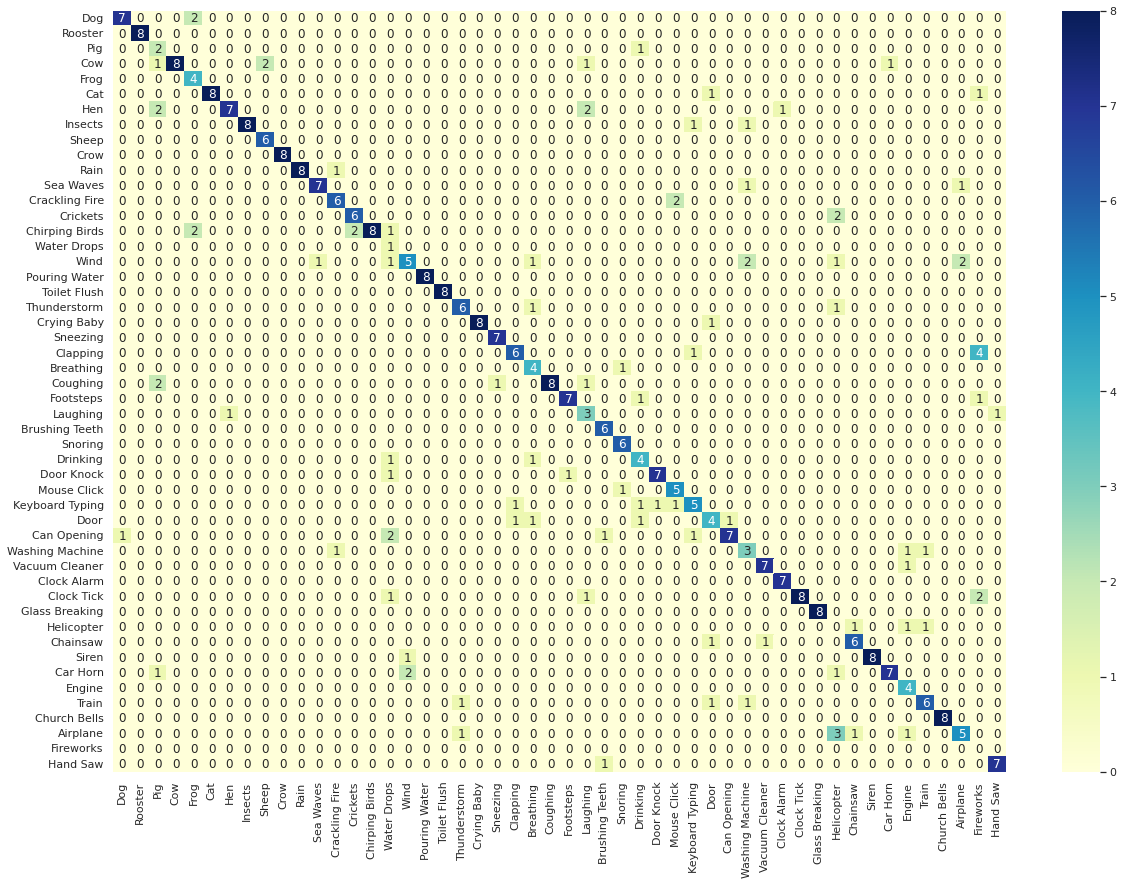

In [ ]:
#Confusion matrix of the final model, 8 is the number of examples of each class in the test
conf_mat = pd.DataFrame(confusion_matrix(fin,true), index=classes_names, columns=classes_names)
plt.figure(figsize = (20,14))

sb.heatmap(conf_mat, annot=True, cmap="YlGnBu")

# TIME-COMPLEXITY

In [ ]:
#up until now we saved for the amchine learning techniques the time elapsed, for the neural
#networks we multuply the time it take for each epoch by the number of epochs

nn_times = [50, 140, 2200, 2200+140]
for time in nn_times:
  time_elapsed.append(time)

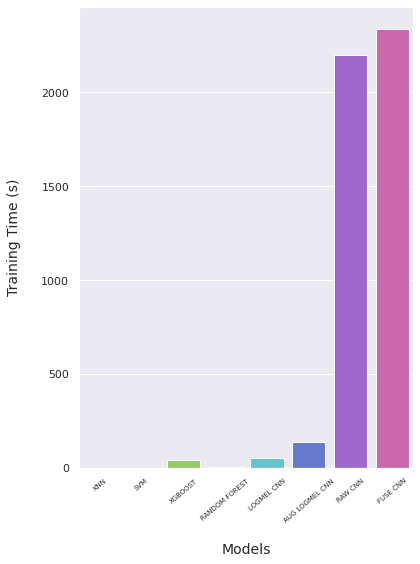

In [ ]:
model_names = ["KNN", "SVM", "XGBOOST", "RANDOM FOREST", "LOGMEL CNN", "AUG LOGMEL CNN", "RAW CNN", "FUSE CNN"]
plt.figure(figsize = (6,8))
sb.set_theme()
sb.barplot(x=model_names, y=time_elapsed, palette = 'hls')
plt.xticks(rotation=40,fontsize=7)
plt.xlabel("Models",fontsize=14, labelpad=20)
plt.ylabel("Training Time (s)",fontsize=14, labelpad=20)

plt.tight_layout()